# Cell States for Model 1a on Folsom Reservoir
In experiment 7, we found that Folsom Reservoir performs exceptionally well compared to Shasta, Trinity, New Melones, and performance does not appear to degrade over time. Here, we examine if the Folsom model learns storage states.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor
import os
import copy

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *
from src.models.analyze_lstm_cell import *

In [2]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


## Data Processing

In [3]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Folsom', vars=['inflow', 'outflow', 'storage'])
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear
# Select data window (beginning of 1944 to end of 2022)
df = df['1963-01-01':'2022-12-31'].copy()

In [4]:
# Run data processing pipeline
pipeline_std = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), 
# test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train_std, ts_val_std, ts_test_std = pipeline_std.process_data(df) 

# Separate inputs(X) and targets (y)
# select inflow and doy as input features
X_train_std, X_val_std, X_test_std = ts_train_std[:, :, [0, 3]], ts_val_std[:, :, [0, 3]], ts_test_std[:, :, [0, 3]]
# select outflow as target feature
y_train_std, y_val_std, y_test_std = ts_train_std[:, :, [1]], ts_val_std[:, :, [1]], ts_test_std[:, :, [1]]

In [5]:
dataset_train, dataset_val = (TensorDataset(X_train_std, y_train_std), TensorDataset(X_val_std, y_val_std))
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                    DataLoader(dataset_val, batch_size=1, shuffle=False))

## Train Model

In [6]:
# Model 1a archeticture
input_size = 2 # inflow, doy
hidden_size1 = 30
hidden_size2 = 15
output_size = 1 # outflow
dropout_prob = 0.3
num_layers = 1

In [7]:
torch.manual_seed(0)
folsom_model = LSTMModel1(input_size=input_size, hidden_size1=hidden_size1, 
                          hidden_size2=hidden_size2, output_size=output_size,
                          num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(folsom_model.parameters(), lr=0.001)

In [8]:
# Run training loop
train_losses, val_losses = training_loop(model=folsom_model, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)

Training epochs:   4%|▍         | 41/1000 [04:09<1:37:25,  6.10s/it]


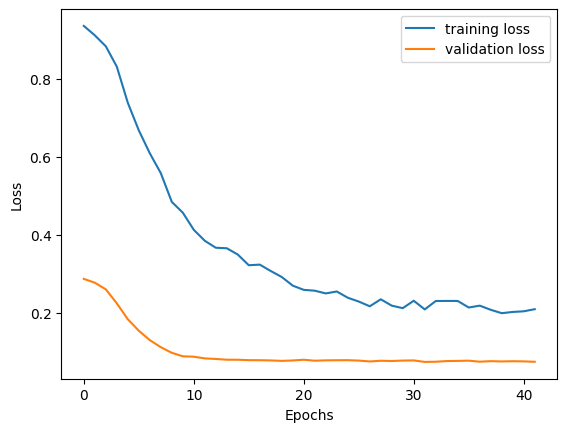

In [9]:
plot_train_val(train_losses=train_losses, val_losses=val_losses)

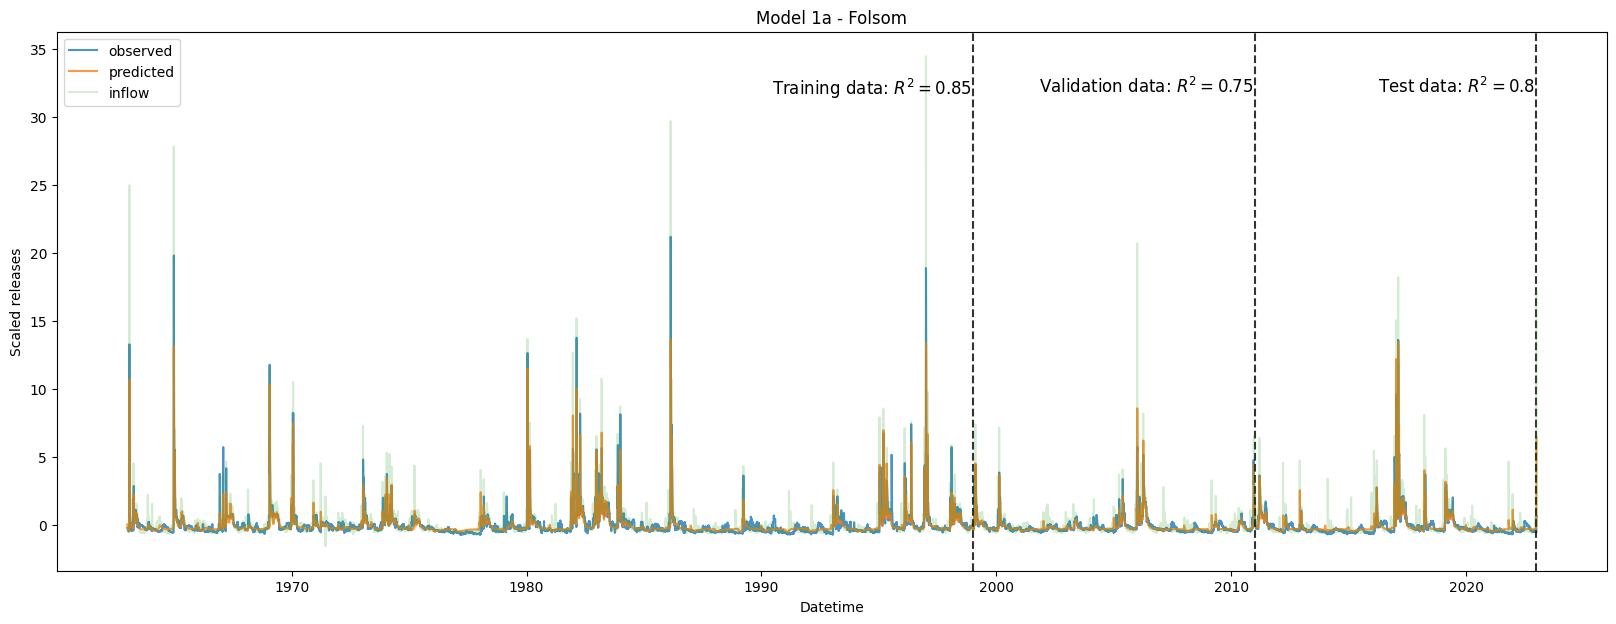

In [11]:
fig, ax = plt.subplots(figsize=(20, 7))
r2_train_1a, r2_val_1a, r2_test_1a = plot_and_eval(folsom_model, X_train_std, X_val_std, X_test_std, y_train_std, y_val_std, y_test_std, datetime_index=df.index, ax=ax, text_ypos=33, alpha=0.8)
ax.plot((df.inflow-df.inflow.mean()) / df.inflow.std(), label='inflow', alpha=0.2)
ax.legend()
ax.set_title('Model 1a - Folsom')
# plt.savefig('report/progress_report_1_23_24/figures/model1a.png',dpi=300)
plt.show()

## Analyze Cell States

In [12]:
# check lengths of train/val/test sets
original_train_len = int(round(df['1963-01-01':'2022-12-31'].shape[0] * pipeline_std.train_frac))
original_val_len = int(round(df['1963-01-01':'2022-12-31'].shape[0] * pipeline_std.val_frac))
original_test_len = df['1963-01-01':'2022-12-31'].shape[0] - (original_train_len + original_val_len)

In [14]:
# Get storage states, shape is (timesteps, )
storage_train = df.storage[:original_train_len].values
storage_val = df.storage[original_train_len:(original_train_len+original_val_len)].values
storage_test = df.storage[(original_train_len+original_val_len):].values

# Get cell states, shape is (# chunks, timesteps, hidden size)
with torch.no_grad():
    folsom_model.eval()
    cell_train = folsom_model(X_train_std)[1][1]
    cell_val = folsom_model(X_val_std)[1][1]
    cell_test = folsom_model(X_test_std)[1][1]

In [19]:
# Calculate correlations for layer 1
correlation_data = {'training: layer1':cell_correlations(cell_states=cell_train[0], storage_states=storage_train),
                    'validation: layer1': cell_correlations(cell_states=cell_val[0], storage_states=storage_val),
                    'testing: layer1': cell_correlations(cell_states=cell_test[0], storage_states=storage_test)}
df_corr = pd.DataFrame(correlation_data)

# Select cells with |correlation| > 0.40
df_corr.loc[np.abs(df_corr['validation: layer1']) > 0.40, :].sort_values(by='validation: layer1', ascending=False)

,training: layer1,validation: layer1,testing: layer1
3,0.374106,0.506571,0.524577
6,0.222705,0.457708,0.319022
18,0.343959,0.456898,0.488402
19,0.348342,0.454235,0.433541
23,0.253564,0.437583,0.388197
8,0.319308,0.416374,0.430629
11,0.319559,0.405496,0.440512
5,-0.395728,-0.508592,-0.557639


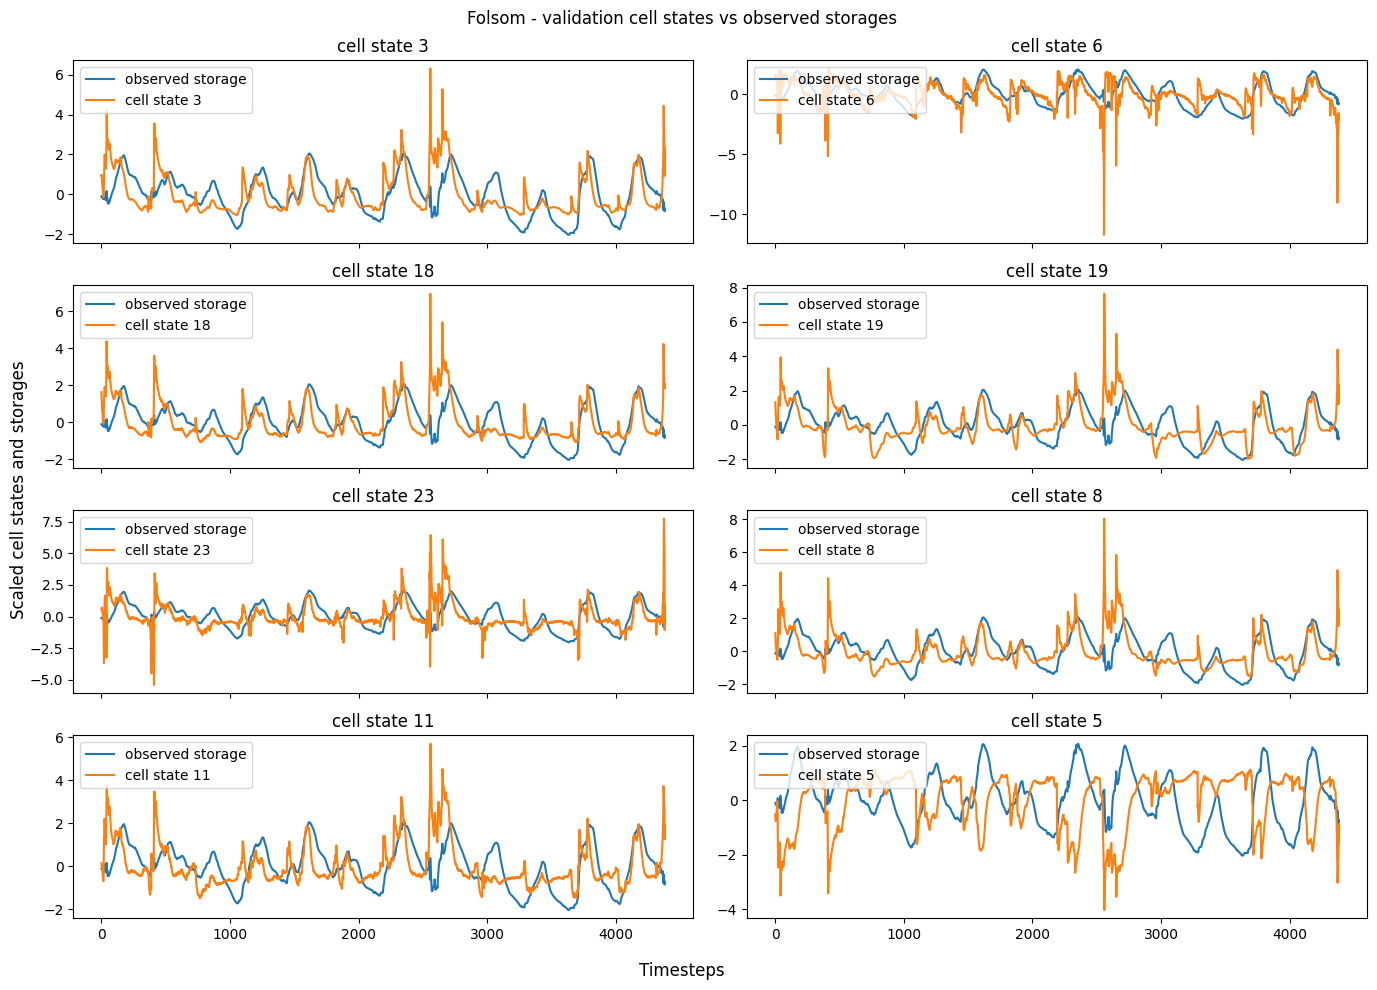

In [25]:
# CHANGE MANUALLY AS NEEDED
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 10), sharex=True)
cell_id_list = [3, 6, 18, 19, 23, 8, 11, 5] # list of cell states to plot
i = 0
for row in range(4):
    for col in range(2):
        plot_storage_cell(cell_states_all=cell_val[0], storage_states=storage_val, cell_id=cell_id_list[i], ax=axes[row, col])
        axes[row, col].legend(loc='upper left')
        axes[row, col].set_title(f'cell state {cell_id_list[i]}')
        i += 1

fig.supxlabel('Timesteps')
fig.supylabel('Scaled cell states and storages')
fig.suptitle('Folsom - validation cell states vs observed storages')
plt.tight_layout()
# plt.savefig('report/progress_report_1_23_24/figures/model1a_cell_states.png', dpi=300)
plt.show()

The model does not appear to have (interpretably) learned storage states.